<div style="display: flex; align-items: center; justify-content: space-between; border-bottom: 3px solid #D0D0D0; padding: 10px; font-family: Arial, sans-serif;">
  <!-- Logo -->
  <img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/Uoc_masterbrand_vertical.png" alt="Logo" style="width: 150px; height: auto;">

  <!-- Detalles -->
  <div style="text-align: right; line-height: 1.6; margin-left: 20px; margin-right: 80px">
    <p style="margin: 0; font-size: 1.2em; font-weight: bold; color: #333;">Proyecto: <span style="color: #878787;">Práctica - Parte 2</span></p>
    <p style="margin: 0; font-size: 1em; font-weight: bold; color: #333;">Notebook: <span style="color: #878787;">Exploración inicial de datos de las actividades</span></p>
    <p style="color: #878787;">Juan Luis González Rodríguez - Visualización de datos</span></p>
  </div>
</div>

# 0. Librerías

In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle as pkl
from IPython.display import display, HTML
import numpy as np
from scipy import stats

# 1.Exploración y limpieza de datos

Cada usuario tiene una carpeta llamada user_1, user_2, user_3, etc. De manera que d entro de cada carpeta hay un archivo CSV llamado Activity.csv. Se carga toda la información de los archivos CSV en un solo DataFrame.

In [27]:
# Creamos un df vacio
df_activity = pd.DataFrame()

# Obtenemos la lista con los paths de los archivos
data_path = os.path.join('..', '0_data', 'MMASH')
csv_files = [os.path.join(root, file) for root, _, files in os.walk(data_path) for file in files if file.endswith('Activity.csv')]

# Iteramos sobre los archivos
for file in csv_files:
    # Leemos el archivo
    df = pd.read_csv(file, usecols=lambda column: column != 'Unnamed: 0')
    # Extraemos el identificador del usuario del nombre del fichero
    user_id = os.path.basename(os.path.dirname(file))
    # Añadimos la columna 'User' al dataframe
    df['User'] = user_id
    # Concatenamos el df al df principal
    df_activity = pd.concat([df_activity, df])

# Reseteamos el índice
df_activity.reset_index(drop=True, inplace=True)

# Se establece user como la primera columna
df_activity = df_activity[['User'] + [col for col in df_activity.columns if col != 'User']]

# Visualizamos el df
df_activity.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User      456 non-null    object
 1   Activity  456 non-null    int64 
 2   Start     456 non-null    object
 3   End       454 non-null    object
 4   Day       456 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 17.9+ KB


In [28]:
# Se muestra un head del df
display(df_activity.head(10))

,User,Activity,Start,End,Day
0,user_1,2,10:00,10:22,1
1,user_1,9,10:37,10:40,1
2,user_1,10,10:40,10:45,1
3,user_1,6,10:55,11:00,1
4,user_1,2,11:00,11:20,1
5,user_1,7,12:00,13:00,1
6,user_1,4,13:30,13:35,1
7,user_1,10,13:35,13:40,1
8,user_1,3,13:40,13:45,1
9,user_1,6,13:55,14:30,1


El dataframe contiene una lista de las categorías de actividades a lo largo del día. Las categorías son (las actividades enumeradas a continuación corresponden al ID numérico de cada actividad en el archivo csv):

1. Durmiendo.
2. Tumbado.
3. Sentado, por ejemplo, estudiando, comiendo y conduciendo.
4. Movimiento ligero, por ejemplo, caminata lenta/media, tareas domésticas y trabajo.
5. Movimiento medio, por ejemplo, caminata rápida y bicicleta.
6. Movimiento pesado, por ejemplo, gimnasio, correr.
7. Comiendo.
8. Uso de pantallas pequeñas, por ejemplo, smartphone y computadora.
9. Uso de pantallas grandes, por ejemplo, TV y cine.
10. Consumo de bebidas con cafeína, por ejemplo, café o coca-cola.
11. Fumando.
12. Consumo de alcohol.

Las columnas 'Start' y 'End' se refieren a la hora del día (horas:minutos) en que ocurrió el evento, mientras que la columna 'Day' se refiere al día en que ocurrió (1 y 2 se refieren al primer y segundo día de grabación de datos, respectivamente). Mientras que la columna User hace referencia al ususario al que pertenece esa actividad.

Se convertirá la variable *Activity* a categórica y se usará un mapeo para asignarle un valor más descriptivo a cada categoría.

In [29]:
activity_mapper = {
    1: 'Durmiendo',
    2: 'Tumbado',
    3: 'Sentado',
    4: 'Mov. ligero',
    5: 'Mov. medio',
    6: 'Mov. pesado',
    7: 'Comiendo',
    8: 'Pant. pequeña',
    9: 'Pant. grande',
    10: 'Cafeína',
    11: 'Fumando',
    12: 'Alcohol'
}

# Se mapean los valores de la columna 'Activity' con el diccionario activity_mapper
df_activity['Activity'] = df_activity['Activity'].map(activity_mapper)

# Se muestra un head del df
display(df_activity.head(10))

,User,Activity,Start,End,Day
0,user_1,Tumbado,10:00,10:22,1
1,user_1,Pant. grande,10:37,10:40,1
2,user_1,Cafeína,10:40,10:45,1
3,user_1,Mov. pesado,10:55,11:00,1
4,user_1,Tumbado,11:00,11:20,1
5,user_1,Comiendo,12:00,13:00,1
6,user_1,Mov. ligero,13:30,13:35,1
7,user_1,Cafeína,13:35,13:40,1
8,user_1,Sentado,13:40,13:45,1
9,user_1,Mov. pesado,13:55,14:30,1


Se revisan los valores NA's de las columnas. Hay algunos csv con valor 0 en el código de actividad, los cuales no se corresponden con ninguna activdad según las indicaciones del dataset en physionet [1]. También se encuentran valores faltantes en otras columnas.

In [30]:
# Se revisan los valores nulos
df_activity.isnull().sum()

User         0
Activity    34
Start        0
End          2
Day          0
dtype: int64

Hay 34 NANs en la columna *Activity* y 2 en la columna de *End*. Vamos a analizarlos por ususarios.

In [31]:
# Se revisan los NAN por usuario
df_activity.groupby('User').apply(lambda x: x.isnull().sum())

/tmp/ipykernel_13993/395817410.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_activity.groupby('User').apply(lambda x: x.isnull().sum())


,User,Activity,Start,End,Day
User,,,,,
user_1,0,1,0,1,0
user_10,0,2,0,0,0
user_11,0,2,0,0,0
user_12,0,1,0,0,0
user_13,0,1,0,0,0
user_14,0,1,0,0,0
user_15,0,1,0,0,0
user_16,0,1,0,0,0
user_17,0,1,0,0,0


Todos los usuarios presentan entre 1 y 3 valores nulos en la columna *Activity*. Por lo que al tratarse de algo sistemático, no parece un error. Sin embargo, se encuentra que en el paper de referencia [2] hay un valor *xiii* que no aparece en PhysioNet y que puede que se haya codificado como 0. Este se corresponde con la toma de muestra de saliva para medir las hormonas. A continuación, revisaremos si los datos con valor NA pueden corresponderse con muestras de saliva.

In [32]:
display(df_activity[df_activity['User'] == 'user_1'])

,User,Activity,Start,End,Day
0,user_1,Tumbado,10:00,10:22,1
1,user_1,Pant. grande,10:37,10:40,1
2,user_1,Cafeína,10:40,10:45,1
3,user_1,Mov. pesado,10:55,11:00,1
4,user_1,Tumbado,11:00,11:20,1
5,user_1,Comiendo,12:00,13:00,1
6,user_1,Mov. ligero,13:30,13:35,1
7,user_1,Cafeína,13:35,13:40,1
8,user_1,Sentado,13:40,13:45,1
9,user_1,Mov. pesado,13:55,14:30,1


El ususario 1 tiene 2 muestras de saliva, una antes de irse a dormir y otra al despertarse segun su el fichero *saliva.csv* y según su fichero *sleep.csv* este se va a dormir a las 00:46 del día 2 y se levanta a las 7:30 del día 2. Por lo que para este caso en concreto sí parece tener sentido que sea la toma de la muestra de saliva antes de irse a dormir. No obstante no se recoge correctamente el tiempo de durmiendo (de 00:25 a 00:30) y solo hay una presunta toma de la muestra de saliva en lugar de 2.

Se carga la información de los momentos de irse a la cama y de depertarse de cada usuario para comparar.

In [33]:
df_sleep = pkl.load(open('../0_data/clean_MMASH/sleep_clean.pkl', 'rb'))[['User', 'In Bed Time', 'Out Bed Time']]
display(df_sleep)

,User,In Bed Time,Out Bed Time
0,user_1,00:46,03:31
1,user_1,03:57,07:30
2,user_2,00:50,06:22
3,user_3,22:29,05:52
4,user_4,00:57,07:10
5,user_5,23:56,06:42
6,user_6,02:27,09:02
7,user_7,00:28,08:02
8,user_8,00:17,07:13
9,user_9,00:30,11:00


A continuación, se itera usuario por usuario para obtener los datos de actividad y analizar cómo corregir los valores nulos y determinar si hay algún error en los datos, como un gap en el tiempo.

In [34]:
# Mostramos para cada usuario el df_activity en 3 columnas
unique_users = df_activity['User'].unique()
html_str = '<div style="display: flex; flex-wrap: wrap;">'

for user in unique_users:
    user_df = df_activity[df_activity['User'] == user]
    html_str += f'<div style="flex: 1; min-width: 30%; padding: 10px;">'
    html_str += f'<h3>User: {user}</h3>'
    html_str += user_df.to_html()
    html_str += '</div>'

html_str += '</div>'
display(HTML(html_str))

,User,Activity,Start,End,Day
0,user_1,Tumbado,10:00,10:22,1
1,user_1,Pant. grande,10:37,10:40,1
2,user_1,Cafeína,10:40,10:45,1
3,user_1,Mov. pesado,10:55,11:00,1
4,user_1,Tumbado,11:00,11:20,1
5,user_1,Comiendo,12:00,13:00,1
6,user_1,Mov. ligero,13:30,13:35,1
7,user_1,Cafeína,13:35,13:40,1
8,user_1,Sentado,13:40,13:45,1
9,user_1,Mov. pesado,13:55,14:30,1


Tras una revisión humana, se ha observado que se deben realizar las siguientes correcciones:

- User 1: se elimina la fila con índice 30 y se prolonga el tiempo de la anterior hasta las 9:20.
- User 4: Se elimina la fila 41 y se prolonga la fila 40 hasta el tiempo final de la 41.
- User 17: Se toma el tiempo de inicio de la fila 62 y se elimina. Este tiempo se establece como tiempo de inicio de la fila 63.
- User 21: Se elimina la fila 78 y se cambia el nombre de la actividad de la fila 85 por 'Durmiendo'.
- User 2: Se toma el valor inicial de la fila 112, se eliminan las filas 112, 113, 114 y 115. Se establece una nueva fila de actividad 'Durmiendo' con el valor inicial y el valor final como 8:55.
- User 12: Se toma el valor inicial de la fila 132 y el final de la 134. Unimos las filas 132, 133 y 134 en una sola fila con el valor inicial y final anteriormente comentados y actividad 'Durmiendo'.
- User 15: Se sustituye la actividad de la fila 150 por 'Durmiendo'.
- User 8: Se elimina la fila 162. Se elimina la fila 169. Se unen con la hora de inicio de la fila 168 y la de final de la 170 en una sola fila con actividad 'Durmiendo'.
- User 11: Eliminamos la fila 190. Se cambia el valor de la actividad en la fila 205 por 'Durmiendo'.
- User 22: Se cambia el valor de la actividad en la fila 227 por 'Durmiendo'.
- User 7: Se cambia el valor de la actividad en la fila 236 por 'Durmiendo'.
- User 3: Se cambia el valor de la actividad en la fila 252 por 'Durmiendo'.
- User 10: Se elimina la fila 265. Se cambia el valor de la actividad en la fila 278 por 'Durmiendo'.
- User 18: Se elimina la fila 291. Se unen las filas 299 y 300 en una sola fila con actividad 'Durmiendo' y con el valor de inicio de la 299 y final de la 300.
- User 14: Se cambia el valor de la actividad en la fila 323 por 'Durmiendo'.
- User 13: Se cambia el valor de la actividad en la fila 339 por 'Durmiendo'.
- User 20: Se cambia el valor de la actividad en la fila 344 por 'Durmiendo'.
- User 16: Se cambia el valor de la actividad en la fila 370 por 'Durmiendo'.
- User 6: Se cambia el valor de la actividad en la fila 393 por 'Durmiendo'.
- User 9: Se elimina la fila 401. Se toma el inicio de la fila 412 y el final de la 414. Eliminamos las filas 412, 413 y 414. Se crea una nueva fila con actividad 'Durmiendo' y con el valor de inicio de la 412 y final de la 414.
- User 19: Se toma la hora de inicio de la fila 432 y la final de la 433. Se eliminan las filas 432 y 433. Se crea una nueva fila con actividad 'Durmiendo' y con el valor de inicio de la 432 y final de la 433.
- User 5: Se elimina la fila 443. Se unen las filas 454 y 455 en una sola fila con actividad 'Durmiendo' y con el valor de inicio de la 454 y final de la 455.


In [35]:
# User 1
df_activity.loc[29, 'End'] = '09:20'
df_activity.drop(30, inplace=True)

# User 4
end_time = df_activity.loc[41, 'End']
df_activity.drop(41, inplace=True)
df_activity.loc[40, 'End'] = end_time

# User 17
start_time = df_activity.loc[62, 'Start']
df_activity.drop(62, inplace=True)
df_activity.loc[63, 'Start'] = start_time

# User 21
df_activity.drop(78, inplace=True)
df_activity.loc[85, 'Activity'] = 'Durmiendo'

# User 2
start_time = df_activity.loc[112, 'Start']
day = df_activity.loc[112, 'Day']
df_activity.drop([112, 113, 114, 115], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_2', 'Start': start_time, 'End': '08:55', 'Activity': 'Durmiendo' , 'Day': day}])], ignore_index=False)

# User 12
start_time = df_activity.loc[132, 'Start']
day = df_activity.loc[132, 'Day']
end_time = df_activity.loc[134, 'End']
df_activity.drop([132, 133, 134], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_12', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)

# User 15
df_activity.loc[150, 'Activity'] = 'Durmiendo'

# User 8
df_activity.drop([162, 169], inplace=True)
start_time = df_activity.loc[168, 'Start']
day = df_activity.loc[168, 'Day']
end_time = df_activity.loc[170, 'End']
df_activity.drop([168, 170], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_8', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)

# User 11
df_activity.drop(190, inplace=True)
df_activity.loc[205, 'Activity'] = 'Durmiendo'

# User 22
df_activity.loc[227, 'Activity'] = 'Durmiendo'

# User 7
df_activity.loc[236, 'Activity'] = 'Durmiendo'

# User 3
df_activity.loc[252, 'Activity'] = 'Durmiendo'

# User 10
df_activity.drop(265, inplace=True)
df_activity.loc[278, 'Activity'] = 'Durmiendo'

# User 18
df_activity.drop(291, inplace=True)
start_time = df_activity.loc[299, 'Start']
day = df_activity.loc[299, 'Day']
end_time = df_activity.loc[300, 'End']
df_activity.drop([299, 300], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_18', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)

# User 14
df_activity.loc[323, 'Activity'] = 'Durmiendo'

# User 13
df_activity.loc[339, 'Activity'] = 'Durmiendo'

# User 20
df_activity.loc[344, 'Activity'] = 'Durmiendo'

# User 16
df_activity.loc[370, 'Activity'] = 'Durmiendo'

# User 6
df_activity.loc[393, 'Activity'] = 'Durmiendo'

# User 9
df_activity.drop(401, inplace=True)
start_time = df_activity.loc[412, 'Start']
day = df_activity.loc[412, 'Day']
end_time = df_activity.loc[414, 'End']
df_activity.drop([412, 413, 414], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_9', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)
# User 19
start_time = df_activity.loc[432, 'Start']
day = df_activity.loc[432, 'Day']
end_time = df_activity.loc[433, 'End']
df_activity.drop([432, 433], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_19', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)

# User 5
df_activity.drop(443, inplace=True)
start_time = df_activity.loc[454, 'Start']
day = df_activity.loc[454, 'Day']
end_time = df_activity.loc[455, 'End']
df_activity.drop([454, 455], inplace=True)
df_activity = pd.concat([df_activity, pd.DataFrame([{'User': 'user_5', 'Start': start_time, 'End': end_time, 'Activity': 'Durmiendo', 'Day': day}])], ignore_index=False)

In [36]:
# Se revisan los valores nulos por usuario
df_activity.groupby('User').apply(lambda x: x.isnull().sum())

/tmp/ipykernel_13993/902445348.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_activity.groupby('User').apply(lambda x: x.isnull().sum())


,User,Activity,Start,End,Day
User,,,,,
user_1,0,0,0,0,0
user_10,0,0,0,0,0
user_11,0,0,0,0,0
user_12,0,0,0,0,0
user_13,0,0,0,0,0
user_14,0,0,0,0,0
user_15,0,0,0,0,0
user_16,0,0,0,0,0
user_17,0,0,0,0,0


In [37]:
# Se ordena el df con el siguiente orden: número del usuario, día, hora de inicio
df_activity['User_num'] = df_activity['User'].str.extract(r'(\d+)').astype(int)
df_activity['Day_num'] = df_activity['Day'].astype(int)
df_activity['Start_datetime'] = pd.to_datetime(df_activity['Start'], format='%H:%M')

df_activity = df_activity.sort_values(['User_num', 'Day_num', 'Start_datetime']).reset_index(drop=True)
df_activity.drop(['User_num', 'Day_num', 'Start_datetime'], axis=1, inplace=True)

# Se muestra el df para cada usuario como antes
unique_users = df_activity['User'].unique()
html_str = '<div style="display: flex; flex-wrap: wrap;">'

for user in unique_users:
    user_df = df_activity[df_activity['User'] == user]
    html_str += f'<div style="flex: 1; min-width: 30%; padding: 10px;">'
    html_str += f'<h3>User: {user}</h3>'
    html_str += user_df.to_html()
    html_str += '</div>'
html_str += '</div>'
display(HTML(html_str))

,User,Activity,Start,End,Day
0,user_1,Tumbado,10:00,10:22,1
1,user_1,Pant. grande,10:37,10:40,1
2,user_1,Cafeína,10:40,10:45,1
3,user_1,Mov. pesado,10:55,11:00,1
4,user_1,Tumbado,11:00,11:20,1
5,user_1,Comiendo,12:00,13:00,1
6,user_1,Mov. ligero,13:30,13:35,1
7,user_1,Cafeína,13:35,13:40,1
8,user_1,Sentado,13:40,13:45,1
9,user_1,Mov. pesado,13:55,14:30,1


In [38]:
durations = []

# Se convertien los valores de la columna 'Start' y 'End' con valor '24:00' a '00:00'
df_activity['Start'] = df_activity['Start'].replace('24:00', '00:00')
df_activity['End'] = df_activity['End'].replace('24:00', '00:00')

# Se convierte la columna 'Start' y 'End' a formato datetime
df_activity['Start'] = pd.to_datetime(df_activity['Start'], format='%H:%M')
df_activity['End'] = pd.to_datetime(df_activity['End'], format='%H:%M')

# Se itera sobre cada fila del df
for i in tqdm(range(df_activity.shape[0])):
    # Se obtiene la hora de inicio y fin
    start = df_activity.loc[i, 'Start']
    end = df_activity.loc[i, 'End']

    # Se comprueba si es en el mismo dia (Hora de inicio < Hora de fin)
    if start < end:
        duration = end - start
    else:
        # Se calcula la duración si es de un día a otro
        duration = pd.Timedelta(hours=24) - (start - pd.Timestamp('1900-01-01')) + (end - pd.Timestamp('1900-01-01'))
        
    # Se añade la duración al array de duraciones
    durations.append(duration)

# Se añade la columna 'Duration' al df
df_activity['Duration'] = durations
df_activity['Duration'] = df_activity['Duration'].apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}")

# Convertimos las columnas 'Start' y 'End' de nuevo a formato %H:%M
df_activity['Start'] = df_activity['Start'].dt.strftime('%H:%M')
df_activity['End'] = df_activity['End'].dt.strftime('%H:%M')

# Se muestra algunas filas del df
df_activity.loc[50:70]

100%|██████████| 434/434 [00:00<00:00, 16498.19it/s]


,User,Activity,Start,End,Day,Duration
50,user_2,Alcohol,03:35,03:45,2,00:10
51,user_2,Sentado,08:55,09:15,2,00:20
52,user_3,Comiendo,09:50,10:15,1,00:25
53,user_3,Pant. grande,10:00,10:10,1,00:10
54,user_3,Sentado,10:30,13:30,1,03:00
55,user_3,Mov. pesado,13:30,13:50,1,00:20
56,user_3,Pant. grande,14:10,14:15,1,00:05
57,user_3,Sentado,14:30,16:30,1,02:00
58,user_3,Mov. ligero,17:00,17:10,1,00:10
59,user_3,Tumbado,17:10,18:30,1,01:20


In [39]:
df_activity

,User,Activity,Start,End,Day,Duration
0,user_1,Tumbado,10:00,10:22,1,00:22
1,user_1,Pant. grande,10:37,10:40,1,00:03
2,user_1,Cafeína,10:40,10:45,1,00:05
3,user_1,Mov. pesado,10:55,11:00,1,00:05
4,user_1,Tumbado,11:00,11:20,1,00:20
...,...,...,...,...,...,...
429,user_22,Mov. pesado,21:00,21:40,1,00:40
430,user_22,Sentado,22:30,00:10,1,01:40
431,user_22,Fumando,23:20,23:30,1,00:10
432,user_22,Tumbado,00:20,00:40,2,00:20


Para conocer un poco mejor el conjunto, comenzaremos por visualizar que actividad es la más común en el conjunto de datos. Para ello tendremos en cuenta la duración de cada actividad.

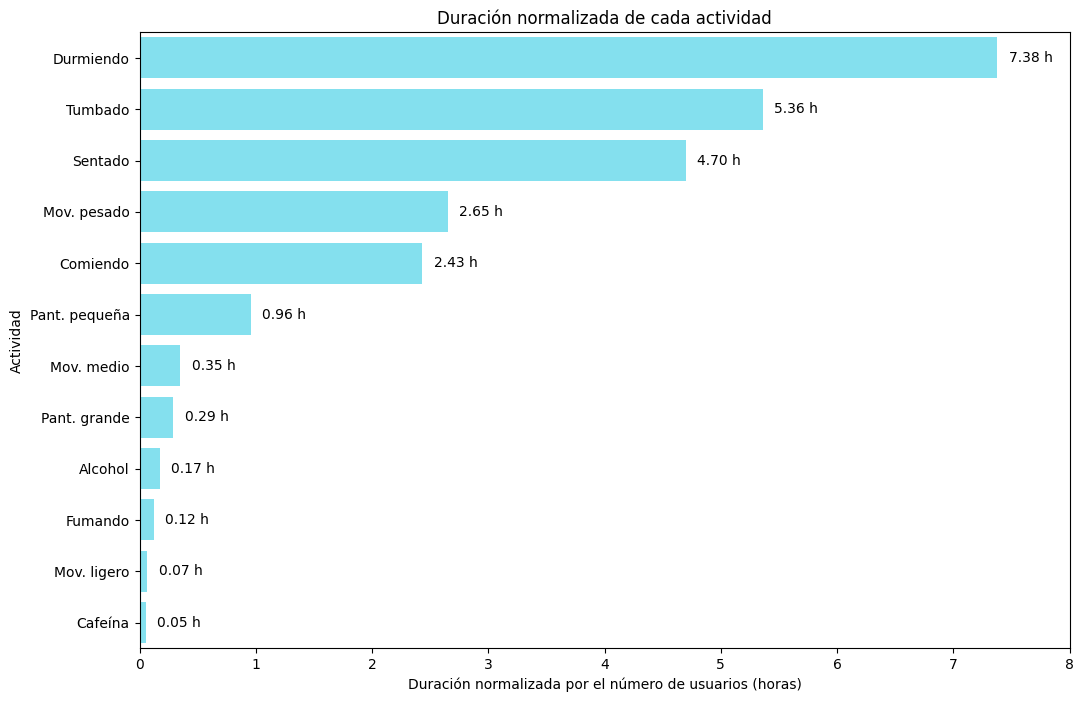

In [40]:
# Conversión de duración a timedelta y luego a horas normalizadas
df_activity['Duration'] = df_activity['Duration'].apply(lambda x: pd.to_timedelta(x + ':00'))
activity_duration = df_activity.groupby('Activity')['Duration'].sum().reset_index()
activity_duration['Duration'] = activity_duration['Duration'].dt.total_seconds() / 3600
activity_duration['Duration'] /= len(unique_users)

# Ordenar las actividades por duración descendente
activity_duration = activity_duration.sort_values('Duration', ascending=False)

# Gráfico de barras mejorado
plt.figure(figsize=(12, 8))
sns.barplot(x='Duration', y='Activity', data=activity_duration, color='#73EDFF')

# Añadir etiquetas de duración al final de las barras
for i, row in enumerate(activity_duration.itertuples()):
    plt.text(row.Duration + 0.1, i, f"{row.Duration:.2f} h", va='center', color='black')

# Etiquetas y título
plt.xlabel('Duración normalizada por el número de usuarios (horas)')
plt.ylabel('Actividad')
plt.title('Duración normalizada de cada actividad')
plt.xlim(0, 8)

plt.show()


La gráfica muestra la duración normalizada (calculada como la suma de la duración de todas las actividades port tipo divididas entre 22 ususarios) por usuario de diversas actividades, ordenadas de mayor a menor. Durmiendo, Tumbado y Sentado son las actividades predominantes, mientras que las de menor duración incluyen Mov. ligero y Cafeína. El diseño es claro, con barras etiquetadas y un solo color que enfoca la atención en la longitud.

A continuación mostraremos qué actividades son más frecuentes a lo largo de cada momento.

In [41]:
# Frecuencia
freq = '15min'

# Se calcula dos columnas datetime para el inicio y fin de cada actividad
df_activity['Start_datetime'] = pd.to_datetime(df_activity['Day'].astype(str) + ' ' + df_activity['Start'], format='%d %H:%M')
df_activity['End_datetime'] = pd.to_datetime(df_activity['Day'].astype(str) + ' ' + df_activity['End'], format='%d %H:%M')

# Calculamos la fecha y hora mínima de inicio y la fecha y hora máxima de fin
start_min = df_activity['Start_datetime'].min()
end_max = df_activity['End_datetime'].max()

# Se crea un rango de frecuencia para el tiempo
time_range = pd.date_range(start_min, end_max, freq=freq)

# Creamos un df con el rango de tiempo como fila y las actividades como columnas
df_time_activity = pd.DataFrame(index=time_range, columns=activity_mapper.values()).replace({pd.NaT: 0})
df_time_activity = df_time_activity.infer_objects(copy=False)

# Se itera el df_activity añadiendo 1 a las celdas correspondientes.
for i in tqdm(range(df_activity.shape[0])):
    # Se obtienen la fecha y hora de inicio y fin
    start = pd.to_datetime(f"{df_activity.loc[i, 'Day']} {df_activity.loc[i, 'Start']}", format='%d %H:%M')
    end = pd.to_datetime(f"{df_activity.loc[i, 'Day']} {df_activity.loc[i, 'End']}", format='%d %H:%M')

    # Se obtiene la actividad
    activity = df_activity.loc[i, 'Activity']

    # Se observa dentro de qué rangos hay al menos un segundo de esa actividad puede ser que la actividad sea 
    # más pequeña que el rango pero también sumaremos 1, o que sea más grande y sumaremos 1 a varios rangos.
    # Se itera sobre time_range y se añade 1 al rango de celdas de manera que el start del rango sea el inmediatamente
    # anterior al start de la actividad y el end del rango sea el inmediatamente posterior al end de la actividad.
    for time in time_range:
        if time <= start and time + pd.Timedelta(freq) > start:
            df_time_activity.loc[time, activity] += 1
        elif time >= start and time + pd.Timedelta(freq) <= end:
            df_time_activity.loc[time, activity] += 1
        elif time < end and time + pd.Timedelta(freq) >= end:
            df_time_activity.loc[time, activity] += 1

# Se muestra el head
df_time_activity.head()

/tmp/ipykernel_13993/3774282195.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_time_activity = pd.DataFrame(index=time_range, columns=activity_mapper.values()).replace({pd.NaT: 0})
100%|██████████| 434/434 [00:01<00:00, 237.86it/s]


,Durmiendo,Tumbado,Sentado,Mov. ligero,Mov. medio,Mov. pesado,Comiendo,Pant. pequeña,Pant. grande,Cafeína,Fumando,Alcohol
1900-01-01 00:35:00,0,1,0,0,0,0,0,0,0,0,0,0
1900-01-01 00:50:00,0,1,0,0,0,0,0,0,0,0,0,0
1900-01-01 01:05:00,0,1,0,0,0,0,0,0,0,0,0,0
1900-01-01 01:20:00,0,1,0,0,0,0,0,0,0,0,0,0
1900-01-01 01:35:00,0,1,0,0,0,0,0,0,0,0,0,0


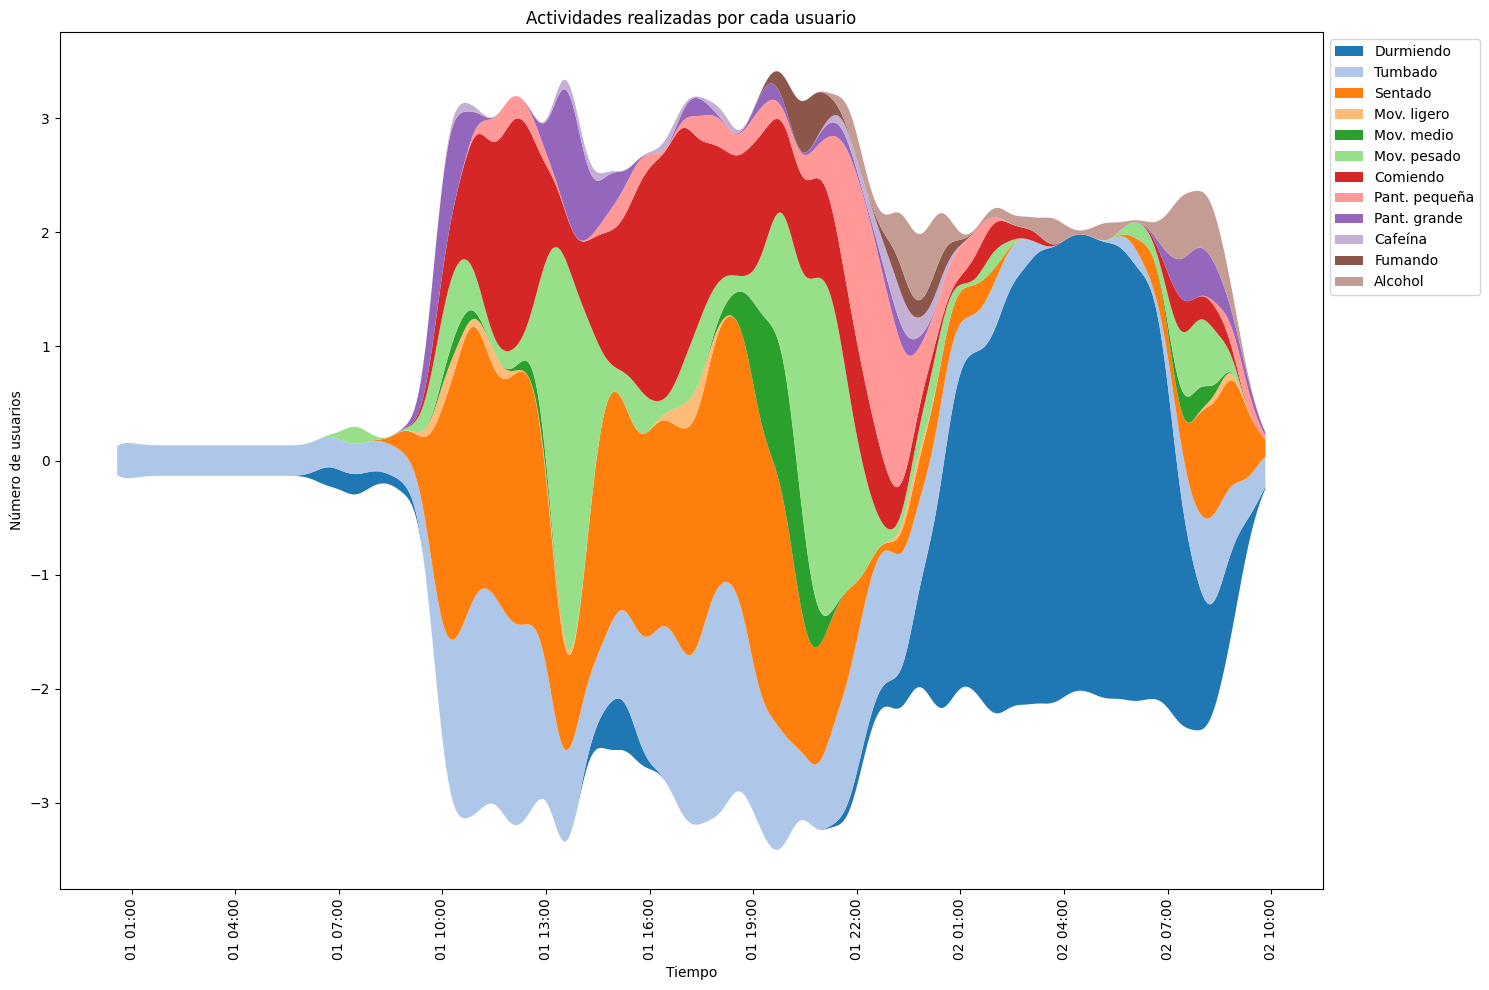

In [42]:
# Factor de suavizado del orden de minutos*60 o más
sd = 20*60

# Convertimos x en números enteros representando los segundos
x = df_time_activity.index
x = x.astype(int) / 10**9

y = df_time_activity.T
# Cambiamos los valores de las columnas a los valores de x
y.columns = x

# Se crea una función para suavizar los valores de y
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

# Se suavizan los valores de y usando un grid
grid = np.linspace(x.min(), x.max(), num=500)
y_smoothed = np.array([gaussian_smooth(x, y_, grid, sd=sd) for y_ in y.values])

# Devolvemos los valores grid a su formato original
grid = pd.to_datetime(grid, unit='s')

# Se crea un stacked plot
fig, ax = plt.subplots(figsize=(15, 10))

# Dame una paleta con 12 tonos pastel diferenciados para cada actividad
colors_pastel = sns.color_palette('tab20', 12)

ax.stackplot(grid, y_smoothed,
             baseline='sym',
             labels=df_time_activity.columns,
             colors=colors_pastel)

ax.set_title('Actividades realizadas por cada usuario')
ax.set_ylabel('Número de usuarios')
ax.set_xlabel('Tiempo')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Formatear las etiquetas del eje x
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d %H:%M'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=3))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Valores anteriores a las 7:00 del día 1 corresponden a un único usuario, por lo que no se tendrán muy en cuenta. Durante la noche del día 2, la actividad principal es *Durmiendo*, reflejando el ciclo de sueño nocturno de los ususarios. En las horas diurnas, hay un notable incremento en actividades como *Mov. ligero* y *Mov. medio*, reflejando mayor actividad física durante el día. Comparando con el día 2, se observa que estas actividades son más frecuentes durante el día 1,ya que los registros finaliza el la mañana del día 1. Se observan dos picos de *Mov. pesado* a las 13:00 y a las 21:00 del día 1, que podrían estar relacionados con actividades específicas como ejercicio físico o tareas domésticas intensas. Estas actividades suelen solaparse con períodos de *Pant. pequeña* y *Pant. grande*, indicando un uso significativo de dispositivos electrónicos, siendo más frecuente el uso de *Pant. grande* por la mañana y *Pant. pequeña* por la tarde del día 1.

Las actividades de *Comiendo* tienen picos breves y bien definidos, concentrándose a las 12:00 y de 17:00 a 18:00 del día 1, horarios típicos de comidas en muchos países. *Alcohol* y *Fumando* aparecen con baja frecuencia, sugiriendo comportamientos menos recurrentes entre los usuarios. El consumo de *Alcohol* se da desde las 22:00 del día 1 hasta las 7:00 del día 2, probablemente debido a una salida nocturna. Las actividades de *Alcohol* y *Fumando* son poco frecuentes, lo que sugiere que estos comportamientos no son habituales entre los usuarios.

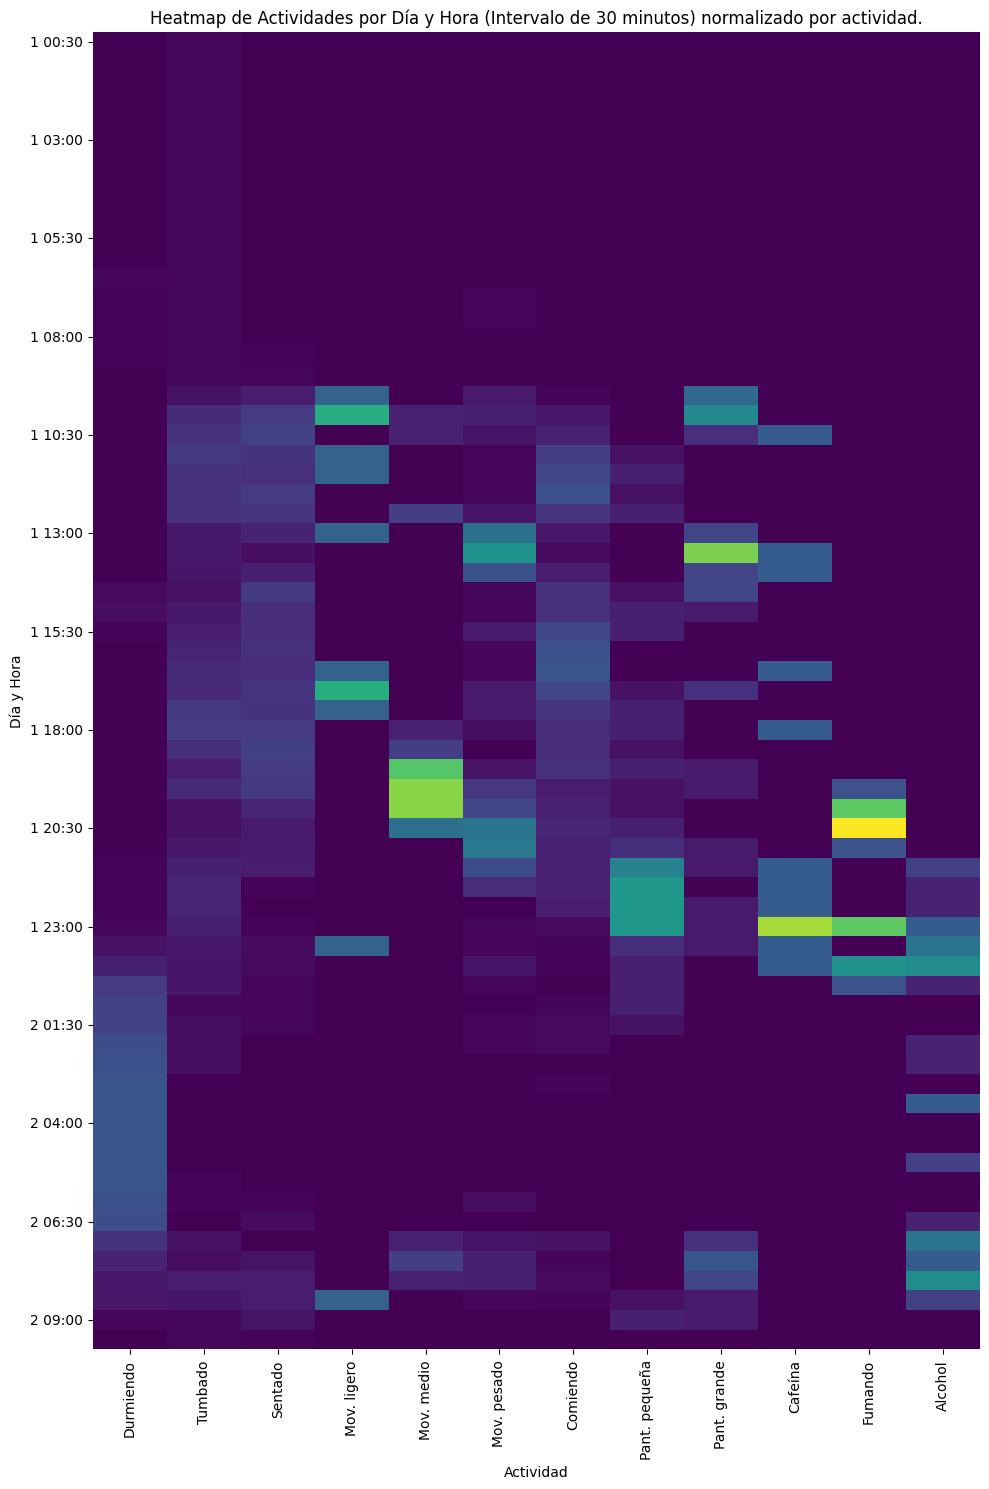

In [43]:
# Define el ancho del intervalo en minutos
interval_width_min = 30

# Define el paso para las etiquetas del eje y
ytick_step = 5

# Agrupa los datos por día y por intervalos de minutos
df_time_activity_grouped = df_time_activity.groupby([df_time_activity.index.date, (df_time_activity.index.hour * 60 + df_time_activity.index.minute) // interval_width_min * interval_width_min]).sum()

# Ajusta el índice para que sea más legible
df_time_activity_grouped.index = [f"{date.day} {hour // 60:02d}:{hour % 60:02d}" for date, hour in df_time_activity_grouped.index]

# Normaliza los valores de cada columna
df_time_activity_grouped_norm = df_time_activity_grouped.div(df_time_activity_grouped.sum(axis=0), axis=1)

# Se crea el heatmap
plt.figure(figsize=(10, 15))
sns.heatmap(df_time_activity_grouped_norm, cmap='viridis', annot=False, yticklabels=df_time_activity_grouped_norm.index[::ytick_step], cbar=False)

# Configura las etiquetas del eje y
plt.yticks(ticks=np.arange(0.5, len(df_time_activity_grouped_norm.index), ytick_step), labels=df_time_activity_grouped_norm.index[::ytick_step])
plt.xlabel('Actividad')
plt.ylabel('Día y Hora')
plt.title(f'Heatmap de Actividades por Día y Hora (Intervalo de {interval_width_min} minutos) normalizado por actividad.')

plt.tight_layout()
plt.show()

Las actividades registradas en el dataset revelan varios patrones interesantes sobre los hábitos y rutinas de los usuarios. En primer lugar, se observa que la actividad *Durmiendo* es predominantemente registrada durante la noche y las primeras horas de la mañana del día 2, lo cual es consistente con los patrones de sueño típicos. Durante el día, actividades como *Sentado*, *Mov. ligero* y *Mov. medio* son más frecuentes, sugiriendo que los usuarios tienen rutinas diarias que incluyen períodos de trabajo, estudio, ejercicio y otras actividades cotidianas. Estando los valores de las actividades de *Mov. medio* en la tarde del día 1.

El uso de *pantallas pequeñas* muestra un uso significativo durante la noche del día 1, lo que puede indicar el tiempo dedicado al uso del móvil antes de irse a dormir. En cuanto al consumo de alimentos y bebidas, las actividades *Comiendo* y *Cafeína* tienen picos específicos durante el día, generalmente alrededor de las horas de comida y en la mañana para el consumo de cafeína. Destaca un pico de cafeína sobre las 23:00 noche del día 1, puede que motivado por el consumo de bebidas energéticas o café.

Las actividades físicas, representadas por *Mov. pesado*, son más frecuentes en ciertos momentos del día, lo que puede indicar horarios específicos dedicados al ejercicio físico, en concreto se centran en las 13:00 y las 19:00 del día 1 como se observaba en el gráfico anterior. Por último, actividades como *Fumando* y *Alcohol* tienen patrones interesantes de comentar. Por un lado, *Fumando* se concentra en momentos muy específicos del día 1, lo que está motivado por el bajo número de personas que fuman. Mientras que *Alcohol* se concentra en el tramo de noche del día 1 al día 2.

# 2. Guardamos el dataframe como un fichero pickle

In [44]:
# Se establece el nombre del archivo 
out_folder = os.path.join('..', '0_data', "clean_MMASH")

filename1 = os.path.join(out_folder, 'activity_clean.pkl')
filename2 = os.path.join(out_folder, 'time_activity_clean.pkl')

# Comprobamos si la carpeta existe, si no la creamos
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Comprobamos si el archivo 1 existe, de ser así lo eliminamos
if os.path.exists(filename1):
    os.remove(filename1)

# Comprobamos si el archivo 2 existe, de ser así lo eliminamos
if os.path.exists(filename2):
    os.remove(filename2)

# Guardamos el df principal
df_activity.to_pickle(filename1)
df_time_activity.to_pickle(filename2)

In [45]:
# Se establece el nombre del archivo 
out_folder = os.path.join('..', '0_data', "clean_MMASH")

filename1 = os.path.join(out_folder, 'activity_clean.csv')
filename2 = os.path.join(out_folder, 'time_activity_clean.csv')

# Comprobamos si la carpeta existe, si no la creamos
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Comprobamos si el archivo 1 existe, de ser así lo eliminamos
if os.path.exists(filename1):
    os.remove(filename1)

# Comprobamos si el archivo 2 existe, de ser así lo eliminamos
if os.path.exists(filename2):
    os.remove(filename2)

# Guardamos el df principal en formato CSV
df_activity.to_csv(filename1, index=False)
df_time_activity.reset_index(inplace=True)
df_time_activity.to_csv(filename2, index=False)

# Bibliografía

[1] Rossi, A., Da Pozzo, E., Menicagli, D., Tremolanti, C., Priami, C., Sirbu, A., Clifton, D., Martini, C., & Morelli, D. (n.d.). Multilevel Monitoring of Activity and Sleep in Healthy people (Version 1.0.0) [Dataset]. PhysioNet. https://doi.org/10.13026/CERQ-FC86

[2] Rossi, A., Da Pozzo, E., Menicagli, D., Tremolanti, C., Priami, C., Sîrbu, A., Clifton, D. A., Martini, C., & Morelli, D. (2020). A Public Dataset of 24-h Multi-Levels Psycho-Physiological Responses in Young Healthy Adults. Data, 5(4), Article 4. https://doi.org/10.3390/data5040091
